## Problem Statement

The goal for this project, and jupyter notebook, is to determine whether the words in the title or the body texts can help determine which particular website the post came from.  Here I webscrape over two different subreddits within the website Reddit.  The two subreddits chosen for the project are World News and Geopolitics.  I wanted two topics with what I felt would be similar posts and therefore, similar words but still be able to make a good enough model to discern between them.  If successful, the model could be modified to be applied to many other texts!

## Executive Summary

Since the first part of the project included pulling data from two subreddits and to dissect that data, I first used the praw wrapper to pull 1000 posts from each site.  After examing the data, some simple feature engineering and test breakdown using a lemmatizer was performed.  The title and body texts were separated and set up to have the models run on them individually.  This was done because numerous amount of posts didn't have body text.

The modeling process began setting up a pipeline with a CountVectorizer estimator. A gridsearch was also set up to find the optimal parameters for score for the models.  The models included a logistic regression, k-nearest neighbors, and multinomial naive Bayes models. All were fitted to the text data and scored.  The best model in accuracy came out to be the title for naive Bayes with the logistic regression being close behind and the best custom made model.

After the modeling some sentiment analysis was performed using VADER.  This allowed me to run another breakdown of the text to see the coefficients for each word, and thus be able to see the words liklihood of being in a subreddit or not.  In the end, the title models performed the best at determining where a post came from.  More tweaks will be needed to get the model to perform better on these subreddits and for others in the future.  

## Outline

- Problem Statement
- Executive Summary
- Outline 
- Imports
- Data Scraping
- Data Cleaning
- Modeling
- Logistic Regression
- Multinomial Naive Bayes
- KNN Classification
- Sentiment Analysis
- Conclusion|

## Imports

In [1]:
# Import all libraries needed.
import praw
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

## Data Scraping

In [2]:
# Instantiate Reddit praw wrapper.
reddit = praw.Reddit(client_id = 't7JW0_wT905v4w',     #this is that personal use script key
                     client_secret = 'tyTgFvan_YU5CZg43eMIrWMu9w0', #this is that secret key
                     user_agent = 'Post Splitter',    #Whatever name you gave your application
                     username = 'ChiSoxAl',      #your Reddit user name
                     password = 'gizmo123')      #your Reddit password

In [3]:
# Select first subreddit to draw posts from.
subreddit_news = reddit.subreddit('worldnews')

In [4]:
# Going to select the 1000 "hot" posts within World News subreddit.
news_hot = subreddit_news.hot(limit=1000)

In [5]:
# Creating a dictionary to append all the drawn data to.
topics_dict_news = { "title":[],
                "score":[],
                "id":[],
                "url":[], 
                "comms_num": [],
                "created": [],
                "body":[]}

for item in news_hot:
    topics_dict_news["title"].append(item.title)
    topics_dict_news["score"].append(item.score)
    topics_dict_news["id"].append(item.id)
    topics_dict_news["url"].append(item.url)
    topics_dict_news["comms_num"].append(item.num_comments)
    topics_dict_news["created"].append(item.created)
    topics_dict_news["body"].append(item.selftext)

In [6]:
# Turn the dictionary into a dataframe and view first few rows.
news_hot = pd.DataFrame(topics_dict_news)
news_hot.head()

,title,score,id,url,comms_num,created,body
0,A giant manta ray has been filmed appearing to...,3571,cc3edp,https://www.independent.co.uk/news/science/gia...,381,1.562918e+09,
1,Google admits workers listen to private audio ...,53628,cbxdaw,https://www.independent.co.uk/life-style/gadge...,4796,1.562890e+09,
2,Because 'Americans Need Relief Now' From 'Insa...,1698,cc1z1r,https://www.commondreams.org/news/2019/07/11/b...,227,1.562911e+09,
3,Saudi Arabia is reportedly axing laws which gi...,3644,cbwyza,https://www.businessinsider.com/absher-saudi-a...,192,1.562888e+09,
4,Deutsche Bank is being slammed for paying $52 ...,2302,cbyewe,https://markets.businessinsider.com/news/stock...,206,1.562895e+09,


In [7]:
# Check out the shape.
news_hot.shape

(718, 7)

In [8]:
# Select a second subreddit in which to use the Reddit praw wrapper on. Here it will be Geopolitics.
subreddit_geo = reddit.subreddit('geopolitics')

In [9]:
# Going to select 1000 posts 
geo_hot = subreddit_geo.hot(limit=1000)

In [10]:
# Creating a second dictionary in which to append second subreddit data.
topics_dict_geo = { "title":[],
                "score":[],
                "id":[],
                "url":[], 
                "comms_num": [],
                "created": [],
                "body":[]}

for item in geo_hot:
    topics_dict_geo["title"].append(item.title)
    topics_dict_geo["score"].append(item.score)
    topics_dict_geo["id"].append(item.id)
    topics_dict_geo["url"].append(item.url)
    topics_dict_geo["comms_num"].append(item.num_comments)
    topics_dict_geo["created"].append(item.created)
    topics_dict_geo["body"].append(item.selftext)

In [11]:
# Take the dictionary, create a dataframe, and view first few rows.
geo_hot = pd.DataFrame(topics_dict_geo)
geo_hot.head()

,title,score,id,url,comms_num,created,body
0,AUA Atlantic Council’s Scowcroft Center for St...,74,c4wgd3,https://www.reddit.com/r/geopolitics/comments/...,69,1.561442e+09,"Hi everyone, We’re the Transatlantic Security ..."
1,Why Turkey Turned Its Back on the United State...,75,cb645p,https://www.foreignaffairs.com/articles/turkey...,24,1.562732e+09,
2,"What you should know about Africa's massive, 5...",73,cc34pe,https://www.reddit.com/r/geopolitics/comments/...,7,1.562917e+09,\n\n>Leaders from 54 African nations met on S...
3,How likely is it that the United States will w...,134,cbwh5z,https://www.reddit.com/r/geopolitics/comments/...,145,1.562886e+09,So Peter Zeihan has been correct about a numbe...
4,The EU and the Ghost in the Machine: How Brexi...,13,cc274f,https://medium.com/@Brumafriend/the-eu-and-the...,1,1.562912e+09,


In [12]:
# Check out the shape of Geopolitics subreddit.
geo_hot.shape

(884, 7)

## Data Cleaning

In [13]:
# Feature engineer subreddit column to designate these posts came from Worldnews subreddit.
news_hot['subreddit'] = news_hot['created'].map(lambda x: 'worldnews' if x > 1 else 'notnews')

In [14]:
# Check to see if column came in correctly.
news_hot.head()

,title,score,id,url,comms_num,created,body,subreddit
0,A giant manta ray has been filmed appearing to...,3571,cc3edp,https://www.independent.co.uk/news/science/gia...,381,1.562918e+09,,worldnews
1,Google admits workers listen to private audio ...,53628,cbxdaw,https://www.independent.co.uk/life-style/gadge...,4796,1.562890e+09,,worldnews
2,Because 'Americans Need Relief Now' From 'Insa...,1698,cc1z1r,https://www.commondreams.org/news/2019/07/11/b...,227,1.562911e+09,,worldnews
3,Saudi Arabia is reportedly axing laws which gi...,3644,cbwyza,https://www.businessinsider.com/absher-saudi-a...,192,1.562888e+09,,worldnews
4,Deutsche Bank is being slammed for paying $52 ...,2302,cbyewe,https://markets.businessinsider.com/news/stock...,206,1.562895e+09,,worldnews


In [15]:
# Check the shape as well.
news_hot.shape

(718, 8)

In [16]:
# Double check with value count.
news_hot['subreddit'].value_counts()

worldnews    718
Name: subreddit, dtype: int64

In [17]:
# Doing something similar to Geopolitics subreddit.  Creating a column to designate posts that came from sub.
geo_hot['subreddit'] = geo_hot['created'].map(lambda x: 'geo' if x > 1 else 'notnews')

In [18]:
# Check shape.
geo_hot.shape

(884, 8)

In [19]:
# Double check with value count.
geo_hot['subreddit'].value_counts()

geo    884
Name: subreddit, dtype: int64

In [20]:
# Creating list of dataframes to concat together.
data = [news_hot, geo_hot]

In [21]:
# Concatinating Worldnews and Geopolitics dataframes together.
big_data = pd.concat(data)
big_data.shape

(1602, 8)

In [22]:
# Check out data to see if merged properly.
big_data.head()

,title,score,id,url,comms_num,created,body,subreddit
0,A giant manta ray has been filmed appearing to...,3571,cc3edp,https://www.independent.co.uk/news/science/gia...,381,1.562918e+09,,worldnews
1,Google admits workers listen to private audio ...,53628,cbxdaw,https://www.independent.co.uk/life-style/gadge...,4796,1.562890e+09,,worldnews
2,Because 'Americans Need Relief Now' From 'Insa...,1698,cc1z1r,https://www.commondreams.org/news/2019/07/11/b...,227,1.562911e+09,,worldnews
3,Saudi Arabia is reportedly axing laws which gi...,3644,cbwyza,https://www.businessinsider.com/absher-saudi-a...,192,1.562888e+09,,worldnews
4,Deutsche Bank is being slammed for paying $52 ...,2302,cbyewe,https://markets.businessinsider.com/news/stock...,206,1.562895e+09,,worldnews


In [23]:
# Specifically check subreddit column to see if posts show their correct subreddit source
big_data['subreddit'].value_counts()

geo          884
worldnews    718
Name: subreddit, dtype: int64

In [24]:
# Feature engineer subreddit column so geopolitics is 1 and worldnews is 0.  Geopolitics is 1 since more posts 
# were drawn in.
# I am going to set up a logistic regression model for each the text column and the body column.  
big_data['subreddit'] = big_data['subreddit'].map({'geo': 1, 'worldnews':0})

In [25]:
# Check value counts to make sure it matches numbers as above.
big_data['subreddit'].value_counts()

1    884
0    718
Name: subreddit, dtype: int64

In [26]:
# Take a look at the data again to make sure subreddit column looks good.
big_data.head()

,title,score,id,url,comms_num,created,body,subreddit
0,A giant manta ray has been filmed appearing to...,3571,cc3edp,https://www.independent.co.uk/news/science/gia...,381,1.562918e+09,,0
1,Google admits workers listen to private audio ...,53628,cbxdaw,https://www.independent.co.uk/life-style/gadge...,4796,1.562890e+09,,0
2,Because 'Americans Need Relief Now' From 'Insa...,1698,cc1z1r,https://www.commondreams.org/news/2019/07/11/b...,227,1.562911e+09,,0
3,Saudi Arabia is reportedly axing laws which gi...,3644,cbwyza,https://www.businessinsider.com/absher-saudi-a...,192,1.562888e+09,,0
4,Deutsche Bank is being slammed for paying $52 ...,2302,cbyewe,https://markets.businessinsider.com/news/stock...,206,1.562895e+09,,0


In [27]:
# Drop columns deemed not worthy.
big_data.drop(columns=['id', 'url', 'created'], inplace=True)

In [28]:
# Check data again to make sure dropped properly.
big_data.head()

,title,score,comms_num,body,subreddit
0,A giant manta ray has been filmed appearing to...,3571,381,,0
1,Google admits workers listen to private audio ...,53628,4796,,0
2,Because 'Americans Need Relief Now' From 'Insa...,1698,227,,0
3,Saudi Arabia is reportedly axing laws which gi...,3644,192,,0
4,Deutsche Bank is being slammed for paying $52 ...,2302,206,,0


In [29]:
# Rename 'subreddit' column to 'is_geo' to help designate 
big_data.rename(columns={'subreddit': 'is_geo'}, inplace=True)

In [30]:
# Check data (keeping some columns incase want to explore further)
big_data.head()

,title,score,comms_num,body,is_geo
0,A giant manta ray has been filmed appearing to...,3571,381,,0
1,Google admits workers listen to private audio ...,53628,4796,,0
2,Because 'Americans Need Relief Now' From 'Insa...,1698,227,,0
3,Saudi Arabia is reportedly axing laws which gi...,3644,192,,0
4,Deutsche Bank is being slammed for paying $52 ...,2302,206,,0


In [31]:
# Creating a new text only dataframe for NLP.
text_data = big_data.drop(columns=['score','comms_num'])

In [32]:
# Check the new dataframe.
text_data.head()

,title,body,is_geo
0,A giant manta ray has been filmed appearing to...,,0
1,Google admits workers listen to private audio ...,,0
2,Because 'Americans Need Relief Now' From 'Insa...,,0
3,Saudi Arabia is reportedly axing laws which gi...,,0
4,Deutsche Bank is being slammed for paying $52 ...,,0


In [33]:
# Check out the 'title' column
text_data['title'].head()

0    A giant manta ray has been filmed appearing to...
1    Google admits workers listen to private audio ...
2    Because 'Americans Need Relief Now' From 'Insa...
3    Saudi Arabia is reportedly axing laws which gi...
4    Deutsche Bank is being slammed for paying $52 ...
Name: title, dtype: object

In [34]:
# Check out the 'body' column
text_data['body'].head()

0    
1    
2    
3    
4    
Name: body, dtype: object

In [35]:
# Use regex to clean the 'title' column text up
text_data['title'] = text_data['title'].replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('\n\n\S+', '', regex=True).replace('#\S+','', regex = True).replace('@\S+', '', regex=True).replace('\n\S+', '', regex=True).replace('\n\n\n\S+','',regex=True)

In [36]:
# Use regex to clean the 'body' column text up
text_data['body'] = text_data['body'].replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('\n\n\S+', '', regex=True).replace('#\S+','', regex = True).replace('@\S+', '', regex=True).replace('\n\S+', '', regex=True).replace('\n\n\n\S+','',regex=True)

In [37]:
# Function from Heather
def remove_punctuation(text):
    lower = text.lower()  #will change text to all lower case
    exclude = string.punctuation  #punctuation marks
    return "".join(ch for ch in lower if ch not in exclude) #this is going to iterate through each character, then rejoin them

In [38]:
# Really wanted to reinforce the punctuation removal for title text
text_data['title'] = text_data['title'].apply(remove_punctuation)

In [39]:
# Really wanted to do the same for body text 
text_data['body'] = text_data['body'].apply(remove_punctuation)

In [40]:
# Check out the data
text_data.head()

,title,body,is_geo
0,a giant manta ray has been filmed appearing to...,,0
1,google admits workers listen to private audio ...,,0
2,because americans need relief now from insane ...,,0
3,saudi arabia is reportedly axing laws which gi...,,0
4,deutsche bank is being slammed for paying 52 m...,,0


In [41]:
# Going to use Lemmatizer to shave off excess
lemmatizer = WordNetLemmatizer()

In [42]:
# With the help of a function, lemmatize the text and return 
def split_and_lem(string):
    word = ""
    string = string.split(' ')
    for i in string:
        word += (lemmatizer.lemmatize(i) + " ")
    return word

In [43]:
# Apply the lemmatizing function on the title text
text_data['lem_title'] = text_data['title'].apply(split_and_lem)

In [44]:
# Check the data 
text_data.head()

,title,body,is_geo,lem_title
0,a giant manta ray has been filmed appearing to...,,0,a giant manta ray ha been filmed appearing to ...
1,google admits workers listen to private audio ...,,0,google admits worker listen to private audio r...
2,because americans need relief now from insane ...,,0,because american need relief now from insane d...
3,saudi arabia is reportedly axing laws which gi...,,0,saudi arabia is reportedly axing law which giv...
4,deutsche bank is being slammed for paying 52 m...,,0,deutsche bank is being slammed for paying 52 m...


In [45]:
# Use the lemmatizing function on the body text
text_data['lem_body'] = text_data['body'].apply(split_and_lem)

In [46]:
# Check the data
text_data.head()

,title,body,is_geo,lem_title,lem_body
0,a giant manta ray has been filmed appearing to...,,0,a giant manta ray ha been filmed appearing to ...,
1,google admits workers listen to private audio ...,,0,google admits worker listen to private audio r...,
2,because americans need relief now from insane ...,,0,because american need relief now from insane d...,
3,saudi arabia is reportedly axing laws which gi...,,0,saudi arabia is reportedly axing law which giv...,
4,deutsche bank is being slammed for paying 52 m...,,0,deutsche bank is being slammed for paying 52 m...,


## Text is clean and ready to go

## Modeling

## Time to set up data for Logistic Regression model 

In [47]:
# Prep and set up data for train, test, split
# Going to do for both title and body texts separately
X_title = text_data['lem_title']
y = text_data['is_geo']

In [48]:
# Check the data
X_title.head()

0    a giant manta ray ha been filmed appearing to ...
1    google admits worker listen to private audio r...
2    because american need relief now from insane d...
3    saudi arabia is reportedly axing law which giv...
4    deutsche bank is being slammed for paying 52 m...
Name: lem_title, dtype: object

In [49]:
# Check the shape
X_title.shape

(1602,)

In [50]:
# Check the shape
y.shape

(1602,)

In [51]:
# Train, test, split
X_train_title, X_test_title, y_train_title, y_test_title = train_test_split(X_title, y, 
                                                    test_size=0.25,
                                                    random_state=42, 
                                                    stratify=y)

In [52]:
# Instantiate CountVectorizer and LogisticRegression
cv = CountVectorizer()
lr = LogisticRegression()

In [53]:
# Instantiate the pipeline 
pipe = Pipeline([
    ('cv', CountVectorizer()), 
    ('lr', LogisticRegression())
])

In [54]:
# Set up parameters for gridsearch estimators
cvec_params = {
    'lr__penalty': ['l1','l2'],
    'lr__C': [0.001,0.01,0.1,1,10,100],
    'lr__n_jobs': [-1],
    'cv__max_features': [100, 250, 500, 750, 1000, 1500, 2000, 2500],
    'cv__stop_words': [None, 'english'], 
    'cv__ngram_range': [(1,1),(1,2),(1,3),(1,4),(1,5)]
}

In [55]:
# Instantiate a GridSearch for the title text
gs_title = GridSearchCV(pipe, cvec_params, cv=5, verbose=1)

In [56]:
# Fit the model to training data 
gs_title.fit(X_train_title, y_train_title)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_a...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lr__penalty': ['l1', 'l2'], 'lr__C': [0.001, 0.01, 0.1, 1, 10, 100], 'lr__n_jobs': [-1], 'cv__max_features': [100, 250, 500, 750, 1000, 1500, 2000, 2500], 'cv__stop_words': [None, 'english'], 'cv__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [57]:
# Check for the best parameters of Title texts
gs_title.best_params_

{'cv__max_features': 2000,
 'cv__ngram_range': (1, 4),
 'cv__stop_words': None,
 'lr__C': 1,
 'lr__n_jobs': -1,
 'lr__penalty': 'l2'}

In [58]:
# Check for best score
gs_title.best_score_

0.8176519567027477

In [59]:
# Going to set up a new logistic regression model using the best parameters shown
best_lr = LogisticRegression()
cv_lr = CountVectorizer(max_features=1500)

In [60]:
# Convert the X train data
X_train_log_title = pd.DataFrame(cv_lr.fit_transform(X_train_title).todense(),
                          columns = cv_lr.get_feature_names())

In [61]:
# Convert the X test data
X_test_log_title = pd.DataFrame(cv_lr.transform(X_test_title).todense(),
                         columns = cv_lr.get_feature_names())

In [62]:
# Fit the data
title_logreg = best_lr.fit(X_train_log_title, y_train_title)

In [63]:
# Score the training data
title_logreg.score(X_train_log_title, y_train_title)

0.9866777685262281

In [64]:
# Score the testing data
title_logreg.score(X_test_log_title, y_test_title)

0.7980049875311721

In [65]:
# Set up new X data for the body texts
X_body = text_data['lem_body']

In [66]:
# New train, test, split for the body texts
X_train_bod, X_test_bod, y_train_bod, y_test_bod = train_test_split(X_body, y, 
                                                            test_size=0.25, 
                                                            random_state=42, 
                                                            stratify=y)

In [67]:
# Will use the same parameters but instantiating a new Gridsearch
gs_body = GridSearchCV(pipe, cvec_params, cv=5, verbose=1)

In [68]:
# Fit the body data
gs_body.fit(X_train_bod, y_train_bod)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_a...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lr__penalty': ['l1', 'l2'], 'lr__C': [0.001, 0.01, 0.1, 1, 10, 100], 'lr__n_jobs': [-1], 'cv__max_features': [100, 250, 500, 750, 1000, 1500, 2000, 2500], 'cv__stop_words': [None, 'english'], 'cv__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [69]:
# Get the best parameters 
gs_body.best_params_

{'cv__max_features': 100,
 'cv__ngram_range': (1, 1),
 'cv__stop_words': None,
 'lr__C': 0.001,
 'lr__n_jobs': -1,
 'lr__penalty': 'l2'}

In [70]:
# Get the best score
gs_body.best_score_

0.6328059950041632

In [151]:
body_lr = LogisticRegression(C=0.001)
body_cv = CountVectorizer(max_features=100)

In [152]:
X_train_log_body = pd.DataFrame(body_cv.fit_transform(X_train_title).todense(),
                          columns = body_cv.get_feature_names())

In [153]:
X_test_log_body = pd.DataFrame(body_cv.transform(X_test_title).todense(),
                         columns = body_cv.get_feature_names())

In [154]:
body_logreg = body_lr.fit(X_train_log_body, y_train_title)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [155]:
body_logreg.score(X_train_log_body, y_train_title)

0.6644462947543713

In [157]:
body_logreg.score(X_test_log_body, y_test_title)

0.6234413965087282

In [71]:
# Check it all against the baseline model score...
y.mean()

0.5518102372034956

In [72]:
# Function to give quick metric scores
def classifications(y_test, y_predict):
    print('Mean accuracy score %s ' % accuracy_score(y_test, y_predict), '\n')
    print(confusion_matrix(y_test, y_predict), '\n')
    print(classification_report(y_test, y_predict))

In [73]:
# Set up predictions
preds = gs_title.predict(X_test_title)

In [74]:
# Run the function on best title data since that had a better score
classifications(y_test_title, preds)

Mean accuracy score 0.7955112219451371  

[[132  48]
 [ 34 187]] 

              precision    recall  f1-score   support

           0       0.80      0.73      0.76       180
           1       0.80      0.85      0.82       221

   micro avg       0.80      0.80      0.80       401
   macro avg       0.80      0.79      0.79       401
weighted avg       0.80      0.80      0.79       401



## Naive Bayes Model --- Multinomial

In [75]:
# Did logistic regression first... going to do a Naive Bayes Model next on both title and body texts
# Title first
X_train_bayes_title = pd.DataFrame(cv.fit_transform(X_train_title).todense(),
                          columns = cv.get_feature_names())

In [76]:
# Set up X data
X_test_bayes_title = pd.DataFrame(cv.transform(X_test_title).todense(),
                         columns = cv.get_feature_names())

In [77]:
# Instantiate Multinomial Naive Bayes
# Using multinomial over the others because the CountVectorizer will yield a count of the words 
# and multinomial works with data in 1's and 0's
nb_title = MultinomialNB()

In [78]:
# Fit the model 
title_model_nb = nb_title.fit(X_train_bayes_title, y_train_title)

In [79]:
# Score the model on training data
title_model_nb.score(X_train_bayes_title, y_train_title)

0.9725228975853455

In [80]:
# Score the model on test data
title_model_nb.score(X_test_bayes_title, y_test_title)

0.830423940149626

In [81]:
# Body second
# Set up the training data
X_train_bayes_body = pd.DataFrame(cv.fit_transform(X_train_bod).todense(),
                          columns = cv.get_feature_names())

In [82]:
# Set up the test data
X_test_bayes_body = pd.DataFrame(cv.transform(X_test_bod).todense(),
                         columns = cv.get_feature_names())

In [83]:
# Instantiate the multinomial naive bayes model
nb_body = MultinomialNB()

In [84]:
# Fit the model
body_model_nb = nb_body.fit(X_train_bayes_body, y_train_bod)

In [85]:
# Score the training data
body_model_nb.score(X_train_bayes_body, y_train_bod)

0.5520399666944213

In [86]:
# Score the testing data
body_model_nb.score(X_test_bayes_body, y_test_bod)

0.5511221945137157

In [87]:
# Title was better so use that in metric function
preds_nb = title_model_nb.predict(X_test_bayes_title)

In [88]:
# Run the classifications function with title data
classifications(y_test_title, preds_nb)

Mean accuracy score 0.830423940149626  

[[144  36]
 [ 32 189]] 

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       180
           1       0.84      0.86      0.85       221

   micro avg       0.83      0.83      0.83       401
   macro avg       0.83      0.83      0.83       401
weighted avg       0.83      0.83      0.83       401



## Next model will be KNN

In [89]:
# Instantiate and set up pipe
knn_pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [99]:
# Set up parameters
knn_params = {
    'knn__n_neighbors': [3,5,7,9],
    'knn__p': [1,2],
    'knn__n_jobs': [-1],
    'cv__max_features': [100, 250, 500, 750, 1000, 1500, 2000, 2500],
    'cv__stop_words': [None, 'english'], 
    'cv__ngram_range': [(1,1),(1,2),(1,3),(1,4),(1,5)]
}

In [100]:
# Set up the Gridsearch
gs_knn_title = GridSearchCV(knn_pipe, 
                            knn_params, 
                            cv=5, 
                            verbose=1)

In [101]:
# Fit the model on training data
gs_knn_title.fit(X_train_title, y_train_title)

Fitting 5 folds for each of 640 candidates, totalling 3200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3200 out of 3200 | elapsed: 12.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_a...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'knn__n_neighbors': [3, 5, 7, 9], 'knn__p': [1, 2], 'knn__n_jobs': [-1], 'cv__max_features': [100, 250, 500, 750, 1000, 1500, 2000, 2500], 'cv__stop_words': [None, 'english'], 'cv__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [102]:
# Score the data
gs_knn_title.best_score_

0.6969192339716903

In [103]:
# Show the best parameters
gs_knn_title.best_params_

{'cv__max_features': 500,
 'cv__ngram_range': (1, 2),
 'cv__stop_words': None,
 'knn__n_jobs': -1,
 'knn__n_neighbors': 5,
 'knn__p': 1}

In [158]:
knn_best = KNeighborsClassifier(p=1)
knn_cv = CountVectorizer(max_features=500, ngram_range=(1,2), stop_words=None)

In [159]:
X_train_knn_title = pd.DataFrame(knn_cv.fit_transform(X_train_title).todense(),
                          columns = knn_cv.get_feature_names())

In [160]:
X_test_knn_title = pd.DataFrame(knn_cv.transform(X_test_title).todense(),
                         columns = knn_cv.get_feature_names())

In [162]:
knn_model = knn_best.fit(X_train_knn_title, y_train_title)

In [163]:
knn_model.score(X_train_knn_title, y_train_title)

0.7751873438800999

In [164]:
knn_model.score(X_test_knn_title, y_test_title)

0.6309226932668329

## Time for some Sentiment Analysis---

In [104]:
# Import Sentiment Analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [105]:
# Instantiate Analyzer
sia = SentimentIntensityAnalyzer()

In [106]:
# Set up the text so it can be read by analyzer
corpus_title = list(text_data['title'])

In [107]:
# Score the first post to mmake sure it works
sia.polarity_scores(corpus_title[0])

{'neg': 0.0, 'neu': 0.943, 'pos': 0.057, 'compound': 0.4019}

In [108]:
# Set up a Dictionary to collect all of the data produced from the analyzer on the posts
dicts_title = []    

for title in corpus_title:
    scores = sia.polarity_scores(title)
    scores['title'] = title
    dicts_title.append(scores)

# Show the data in a dataframe
df_title = pd.DataFrame(dicts_title)
df_title.head()

,compound,neg,neu,pos,title
0,0.4019,0.000,0.943,0.057,a giant manta ray has been filmed appearing to...
1,0.5994,0.000,0.692,0.308,google admits workers listen to private audio ...
2,0.5719,0.111,0.701,0.188,because americans need relief now from insane ...
3,0.0772,0.045,0.899,0.056,saudi arabia is reportedly axing laws which gi...
4,-0.6124,0.161,0.839,0.000,deutsche bank is being slammed for paying 52 m...


In [109]:
# Add a column showing which subreddit each post came from
df_title['subreddit'] = big_data['is_geo'].values
df_title.head()

,compound,neg,neu,pos,title,subreddit
0,0.4019,0.000,0.943,0.057,a giant manta ray has been filmed appearing to...,0
1,0.5994,0.000,0.692,0.308,google admits workers listen to private audio ...,0
2,0.5719,0.111,0.701,0.188,because americans need relief now from insane ...,0
3,0.0772,0.045,0.899,0.056,saudi arabia is reportedly axing laws which gi...,0
4,-0.6124,0.161,0.839,0.000,deutsche bank is being slammed for paying 52 m...,0


In [110]:
# Check out the shape of the dataframe
df_title.shape

(1602, 6)

In [111]:
# Sort the posts to see which had highest overall positive sentiment
df_title.sort_values(by='compound', ascending=False).head()

,compound,neg,neu,pos,title,subreddit
1026,0.9300,0.0,0.725,0.275,atlanta amsterdam airports sign cargo agreemen...,1
1506,0.9042,0.0,0.701,0.299,a beginning of eastmed friendship and cooperat...,1
1292,0.8910,0.0,0.665,0.335,us president on iran i like to see them call m...,1
1098,0.8885,0.0,0.677,0.323,question how much of the success and triumph o...,1
981,0.8481,0.0,0.523,0.477,with great demographics comes great power why ...,1


In [112]:
# Change the subreddit column back to Geopolitics or Worldnews
df_title['subreddit'] = df_title['subreddit'].map({0: 'World_News', 1: 'Geopolitics'})

Text(0.5, 1.0, 'Average Positive, Negative & Compound Title Scores by Subreddit')

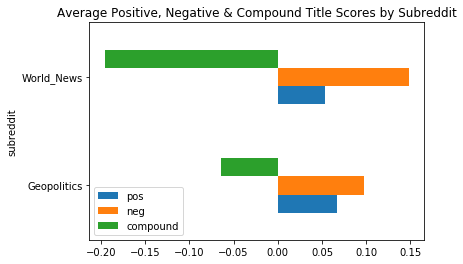

In [113]:
# Making a bar plot showing the average positive, negative, and compound sentiments for both subreddits
df_title.groupby('subreddit').mean()[['pos', 'neg', 'compound']].plot(kind='barh')
plt.title('Average Positive, Negative & Compound Title Scores by Subreddit')

In [114]:
# Setting up a new logistic regression to see which words had highest and lowest affect on classification
logreg = LogisticRegression()

In [115]:
# Setting up a new vectorizer 
vector = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000)

In [116]:
# Transform/Fit the data 
train_title_words = vector.fit_transform(X_train_title)

test_title_words = vector.transform(X_test_title)

In [117]:
# Must turn the X Data into an array 
train_title_words = train_title_words.toarray()

In [118]:
# Check it out to make sure
train_title_words[0:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [119]:
# Check out the words
words = vector.get_feature_names()
print(words)

['00s', '06', '10', '100', '1000', '10000', '100000', '100kmh', '1030', '10th', '11', '1177', '12', '120', '1200', '1248', '126', '130', '13yearold', '14', '140', '14bn', '14th', '15', '150', '150000', '16', '1624yearolds', '17', '176', '18000', '18002100', '1812', '18month', '18yearold', '19142007', '1915', '19452014', '1946', '19602017', '19602019', '19702017', '1972', '1989', '1994', '1998', '1mdb', '1st', '1v1', '20', '200', '2003', '2010s', '2013', '2014', '2015', '2017', '2018', '2019', '201920', '2020', '20202030', '2021', '2022', '2030', '2050', '20th', '210', '2100', '219year', '22', '227', '22bn', '22nation', '24', '24th', '25', '250', '26', '28', '29000', '2bn', '2nd', '30', '300', '3200', '33', '33m', '34', '36', '3600', '37', '38', '3m', '3rd', '40', '400', '40000', '42', '43', '460000', '47m', '4m', '50', '500', '535', '55', '5g', '5k', '60', '600', '61019', '62', '70', '700', '7000', '7080', '74', '75', '758', '88', '95', '9th', 'a350900', 'a380s', 'abandoned', 'abbas', 

In [120]:
# Fit the log
logreg.fit(train_title_words, y_train_title)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [121]:
# Take the coefficients and turn into a dataframe
coef_matrix = pd.DataFrame(logreg.coef_)

In [122]:
# Check it out
w_coef = coef_matrix.T
w_coef.head()

,0
0,0.021831
1,0.036739
2,0.336072
3,0.308575
4,-0.137278


In [142]:
# Make a list combining the word to their corresponding coefficient
words_coef = list(zip(list(logreg.coef_[0]), words))

In [143]:
# Show the coefficients of top words
w_coef[0].sort_values(ascending=False).head()

4085    1.903088
1898    1.530572
4097    1.471519
1699    1.229723
269     1.034269
Name: 0, dtype: float64

In [144]:
# Show the coefficients of lowest words
w_coef[0].sort_values(ascending=False).tail()

633    -1.001554
375    -1.027589
3298   -1.172968
193    -1.245403
3887   -2.050957
Name: 0, dtype: float64

In [146]:
# Turn vocab words into Dataframe with coefficients
words_coef_df = pd.DataFrame(words_coef)
words_coef_df.head()

,0,1
0,0.021831,00s
1,0.036739,06
2,0.336072,10
3,0.308575,100
4,-0.137278,1000


In [147]:
# Rename the columns appropriately
words_coef_df = words_coef_df.rename(columns={0: 'coef', 1: 'word'})

In [148]:
# Check out the data
words_coef_df.head()

,coef,word
0,0.021831,00s
1,0.036739,06
2,0.336072,10
3,0.308575,100
4,-0.137278,1000


In [149]:
# View the Words with corresponding coefficients
words_coef_df.sort_values(['coef'], ascending=False).head(20)

,coef,word
4085,1.903088,what
1898,1.530572,how
4097,1.471519,why
1699,1.229723,geopolitics
269,1.034269,america
3263,0.979431,russia
1293,0.976817,east
3736,0.886419,the
2444,0.856355,middle
1323,0.827754,election


In [150]:
# Check out the lowest coefficient words
words_coef_df.sort_values(['coef'],ascending=True).head(20)

,coef,word
3887,-2.050957,uk
193,-1.245403,after
3298,-1.172968,say
375,-1.027589,arrested
633,-1.001554,british
3695,-0.984883,tax
769,-0.977073,city
1635,-0.976250,french
2186,-0.975995,killed
789,-0.975187,climate


In [167]:
words_coef_df['exp'] = [np.exp(i) for i in words_coef_df['coef']]

In [174]:
top_world_words = words_coef_df.sort_values('exp',ascending=True).reset_index(drop=True).head(10)

In [179]:
top_world_words.to_csv()

',coef,word,exp\n0,-2.0509570107018824,uk,0.12861176184074827\n1,-1.2454030965299372,after,0.287824863540033\n2,-1.172968186964284,say,0.30944707999173854\n3,-1.0275891991285375,arrested,0.3578686715502452\n4,-1.0015541673377437,british,0.3673081390243101\n5,-0.9848830721441314,tax,0.37348289493771697\n6,-0.9770733834913236,city,0.3764110993638843\n7,-0.9762502994783342,french,0.3767210448601757\n8,-0.9759945923783303,killed,0.3768173874232811\n9,-0.9751867766379231,climate,0.3771219094223728\n'

In [181]:
top_world_words

,coef,word,exp
0,-2.050957,uk,0.128612
1,-1.245403,after,0.287825
2,-1.172968,say,0.309447
3,-1.027589,arrested,0.357869
4,-1.001554,british,0.367308
5,-0.984883,tax,0.373483
6,-0.977073,city,0.376411
7,-0.976250,french,0.376721
8,-0.975995,killed,0.376817
9,-0.975187,climate,0.377122


In [176]:
top_geo_words = words_coef_df.sort_values('exp',ascending=False).reset_index(drop=True).head(10)

In [180]:
top_geo_words.to_csv()

',coef,word,exp\n0,1.903088033850786,what,6.706572621666594\n1,1.5305716723328597,how,4.620817660992631\n2,1.4715191124030957,why,4.35584713902202\n3,1.2297233646843546,geopolitics,3.4202832342733203\n4,1.0342692446262263,america,2.8130498330697566\n5,0.9794309962044508,russia,2.66294058746215\n6,0.9768167544761637,east,2.655988108748028\n7,0.8864190817729501,the,2.4264252453207\n8,0.8563552112508365,middle,2.354563149830331\n9,0.8277535266274837,election,2.2881726432286773\n'

top_geo_words

## Conclusion

After checking out the scores from the models, it was clear to see that the title texts were much better at determining which post the subreddit came from.  There was much overfitting seen between the training and testing data in the models.  This could be alleviated by using a TFIDF Vectorizer instead.  The best custom made model THat I can interpret is the logistic regression.  This provided a title text accuracy score of 0.79 on the test data.  Not bad, but very much need for impovement.  The best parameters in the models asked for no stopwords.  This allowed for common words to have higher coefficients for the geopolitics subreddit.  Words like "what", "why", and "how" took the top.  This makes sense since many of the posts were discussion based.  On the other side, the top words in world news were "UK", "French", and "Middle East".  Also makes sense since much of the global news outside of the US centers around those areas.  Better models could have also been fitted and scored like a random forest or SVC and could have provided better scores.